In [1]:
from __future__ import annotations

import sys
sys.path.append("/media/wdp/disk4/git/noiseba/src")  # 添加 src 到模块搜索路径
import numpy as np
import datetime
import matplotlib.pyplot as plt

from scipy.fft import next_fast_len
from pathlib import Path
from obspy import read, Stream
from noiseba.preprocessing import batch_process, get_ccf_parallel, write_ccf_parallel, read_coord, stack_ccf
from noiseba.utils import plot_ccf, snr_optimal_select, energy_symmetry_select

from noiseba.dispersion import fj_spectra, park, radon

# 1. Preprocess seismic data
- demean, detrend, remove instrment response (optional),  filter, decimiate

In [2]:
st = read(r'/media/wdp/disk4/site1_line1/sw_raw_data/453000030Z.sac')
start_time = st[0].stats.starttime + datetime.timedelta(minutes=2)
end_time = st[0].stats.endtime

input_dir = Path(r'/media/wdp/disk4/site1_line1/sw_raw_data')
out_dir = Path(r'./pre_data')

config = {
    "input_dir": input_dir,
    "output_dir": out_dir,
    # "target_rate": 100,      # decimate smapling rate
    "freq_min": 1,            # lower filter
    "freq_max": 45,           # upper filter
    "start_time": start_time, # cut begin
    "end_time": end_time,     # cut end
    "max_workers": 36         # used cpu cores
}

batch_process(**config)


Reading...
---------------Processing 20 Trace-----------------




Processing traces: 100%|██████████| 20/20 [00:01<00:00, 12.89it/s]




-------------------------Done-----------------------------------


# 2. Compute cross correlation function

In [3]:
input_dir = "/media/wdp/disk4/git/noiseba/examples/pre_data/*.Z.sac"
output_dir = Path('./CCF_ZZ')

st = read(input_dir)
st.detrend(type='demean')
st.detrend(type='linear')

coord = read_coord('/media/wdp/disk4/site1_line1/sw_raw_data/xy.txt')
operator = np.ones(10) / 10
dt = round(st[0].stats.delta, 4)
win_sec = 20 # time window to compute ccf
win_len = next_fast_len(int(win_sec / dt)) # window length in points
step = int(0.5 * win_len) # overlap between windows
freq_min = 1
freq_max = 40
cor_time_begin = -2.5  # ccf start time in seconds
cor_time_end = 2.5

ccf_dict, ccf_distance = get_ccf_parallel(
    stream=st,
    operator=operator,
    taper=0.05,
    win_len=win_len,
    step=step,
    coord=coord,
    cor_time_begin=cor_time_begin,
    cor_time_end=cor_time_end,
    n_jobs=36,
)


Computing CCFs...: 100%|██████████| 190/190 [00:05<00:00, 33.90it/s]


### 2.1 **[Optional]**, ccf segment filter
Base on:
- Cross-correlation function signal-to-noise ratio
- Cross-correlation function symmetry

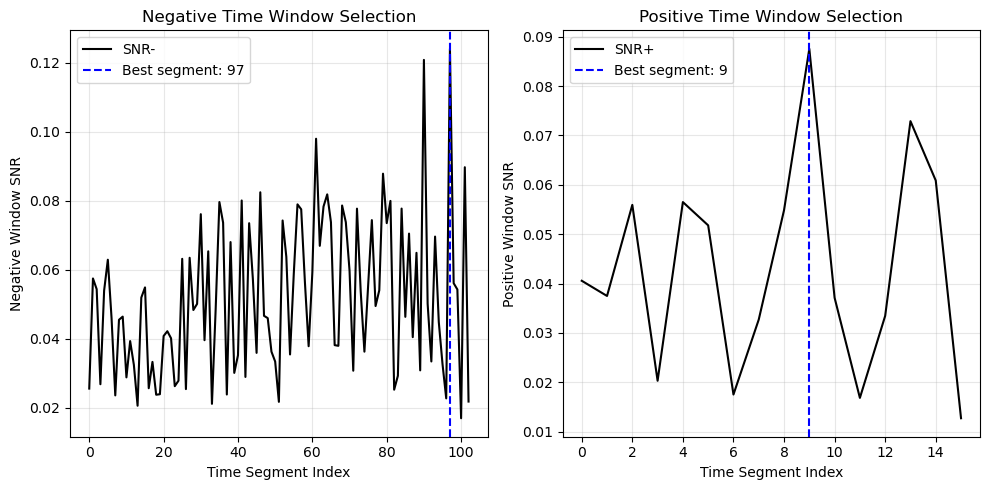

In [ ]:
# Estimate the velocity range of surface waves.
# Potential issue: a narrow velocity range leads to a short time window,
# which may fail to capture the surface wave, yielding zero signal.
# To mitigate this, consider increasing the vmax limit. I will fit it later
vmin = 100
vmax = 800
ccf_snr_select, *_ = snr_optimal_select(
    ccf_dict,
    ccf_distance,
    dt,
    vmin=vmin,
    vmax=vmax,
    plot_results=True,
)

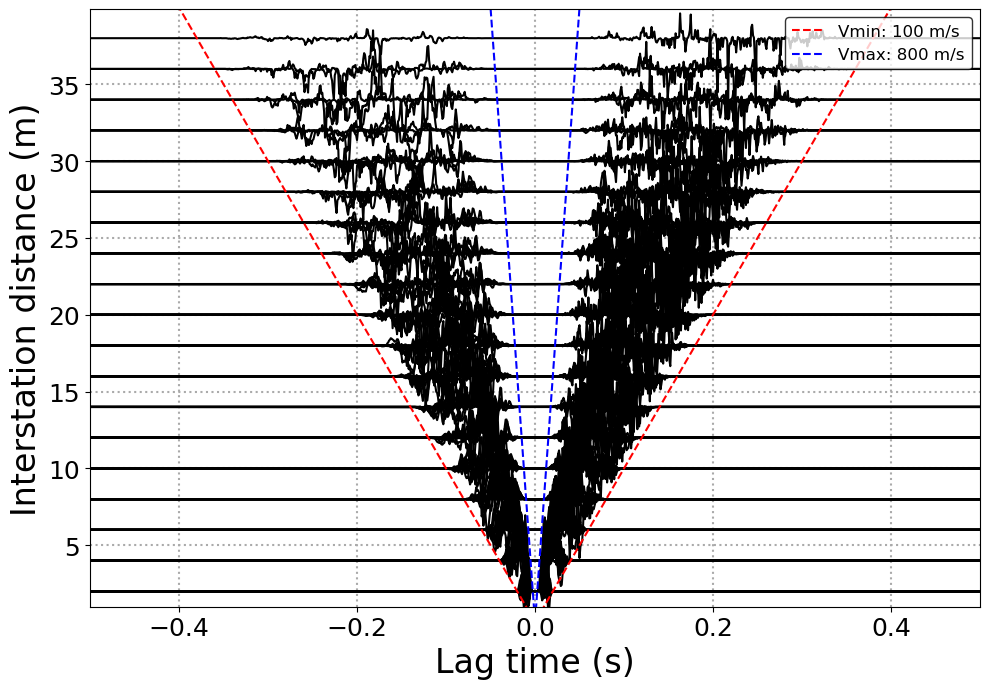

In [5]:
plot_ccf(ccf_snr_select, ccf_distance, dt, 0.5, vmin, vmax,)

In [6]:
ccf_symmetry_select = energy_symmetry_select(
    ccf_dict,
    ccf_distance,
    dt,
    vmin=vmin,
    vmax=vmax,
    pct=20,
    stack_method="pws",
    signal_truncation=True,
    normalize=True,
)


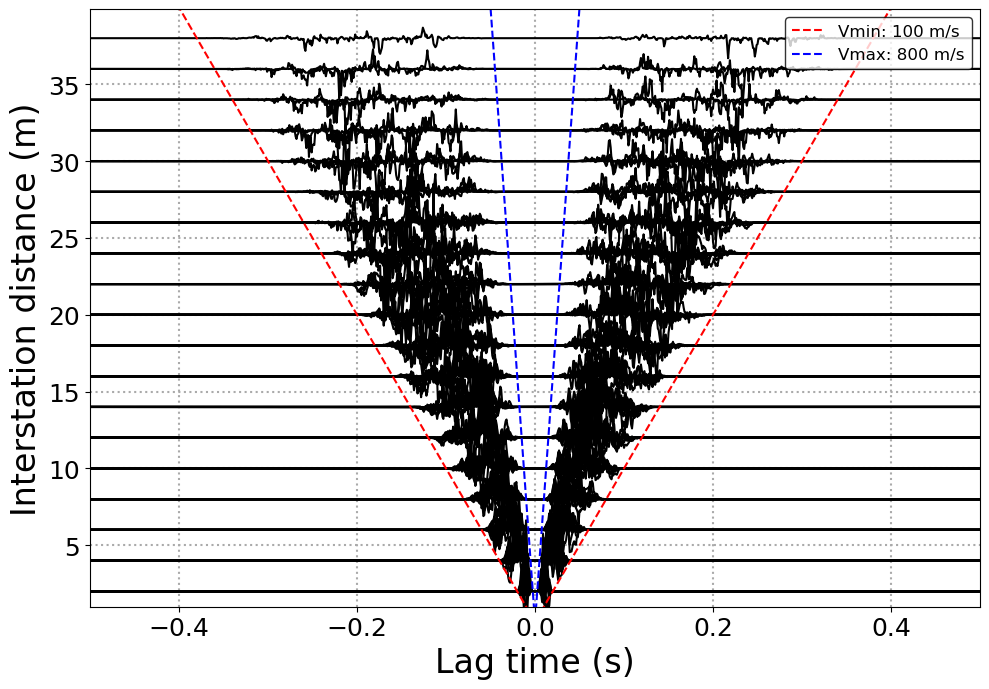

In [7]:
plot_ccf(ccf_symmetry_select, ccf_distance, dt, 0.5, vmin, vmax)

### ✅ Let's store the ccf results before and after window selection to see the difference

In [11]:
# raw
write_ccf_parallel(ccf_dict, ccf_distance, 
            output_dir='./output/raw/', 
            freq_min=freq_min, 
            freq_max=freq_max, 
            dt=dt, 
            start_time=cor_time_begin,
            method='pws', 
            nu=2.0,
            n_jobs=36)

# snr_optimal
write_ccf_parallel(ccf_snr_select, ccf_distance, 
            output_dir='./output/snr_optimal/', 
            freq_min=freq_min, 
            freq_max=freq_max, 
            dt=dt, 
            start_time=cor_time_begin,
            method='pws', 
            nu=2.0,
            n_jobs=36)

# symmetry select
write_ccf_parallel(ccf_symmetry_select,
            ccf_distance, 
            output_dir='./output/symmetry_select/', 
            freq_min=freq_min, 
            freq_max=freq_max, 
            dt=dt, 
            start_time=cor_time_begin,
            method='pws', 
            nu=2.0,
            n_jobs=36)

Writing CCFs...: 100%|██████████| 190/190 [00:01<00:00, 173.36it/s]


# 3. calculate Dispersion Spectrum

### 👓 Park 

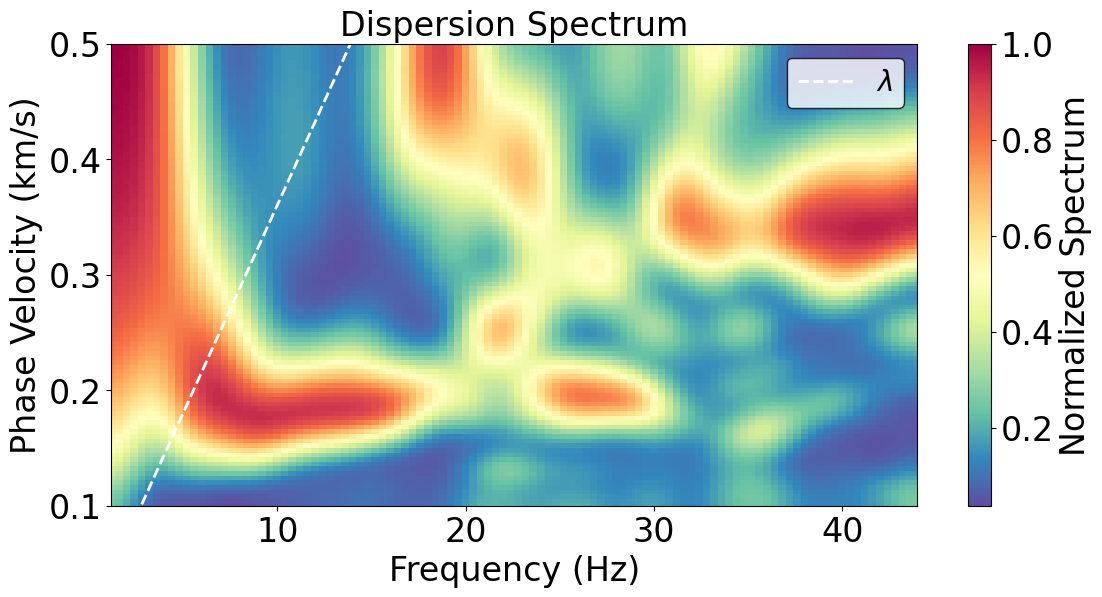

In [ ]:
config = {
    'freq_min': 1,
    'freq_max': 40,
    'vel_min': 100,
    'vel_max': 500,
    'num_vel': 101,
    'part': 'both', # you can choose 'left', 'right' or 'both', to select the best one
}

park('./output/raw/', **config)

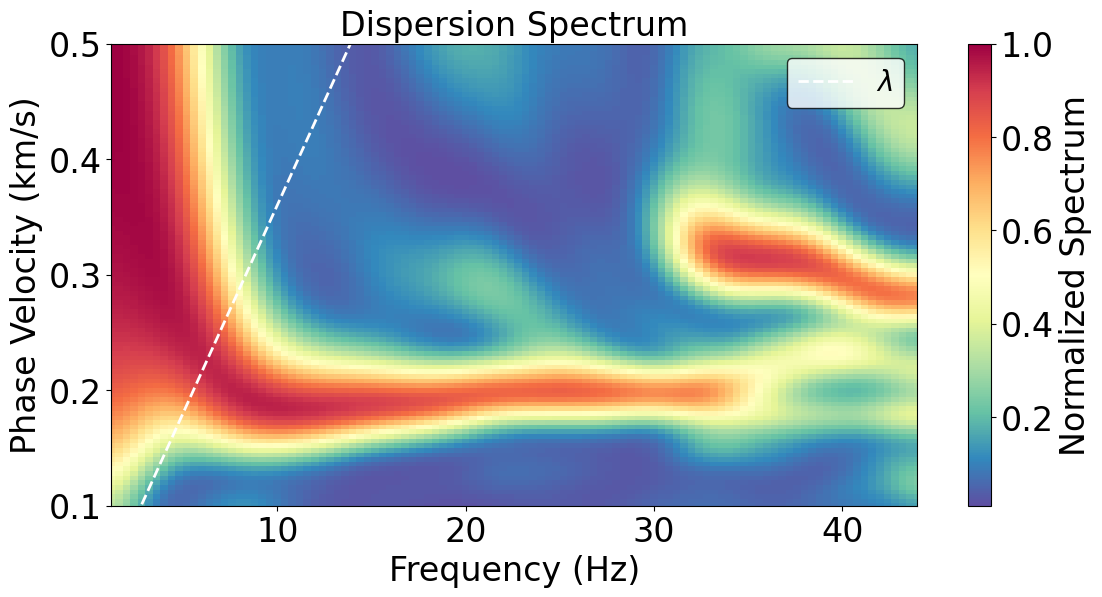

In [14]:
config = {
    'freq_min': 1,
    'freq_max': 40,
    'vel_min': 100,
    'vel_max': 500,
    'num_vel': 101,
    'part': 'left', 
}
park('./output/snr_optimal/', **config)

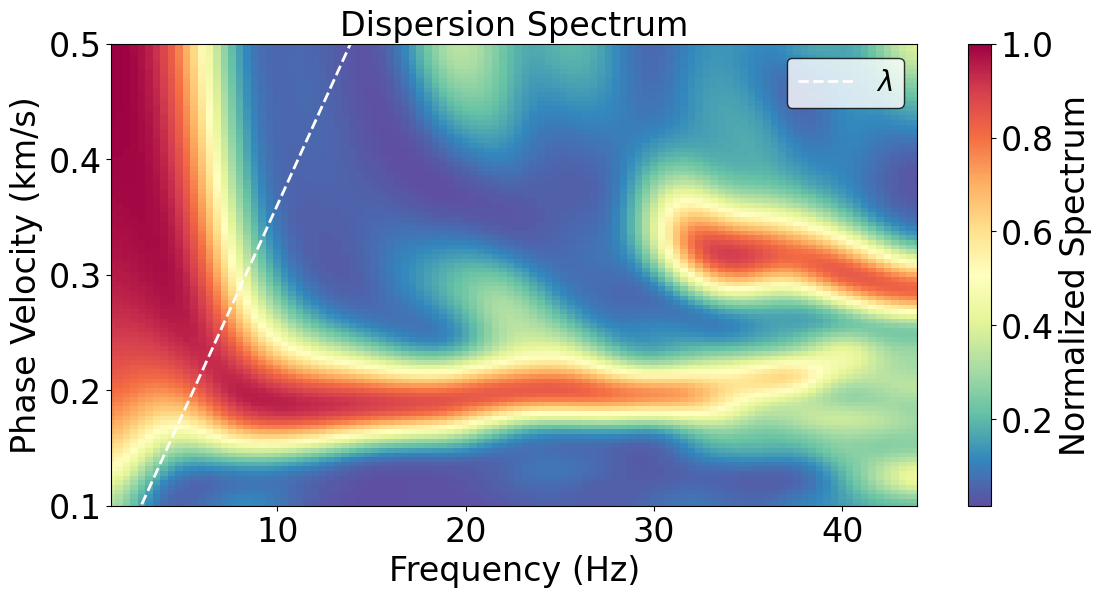

In [18]:
config = {
    'freq_min': 1,
    'freq_max': 40,
    'vel_min': 100,
    'vel_max': 500,
    'num_vel': 101,
    'part': 'left', 
}
park('./output/symmetry_select/', **config)

### 🕶️ High-resolution linear Radon transform

Solving frequencies: 100%|██████████| 87/87 [00:00<00:00, 25138.09it/s]


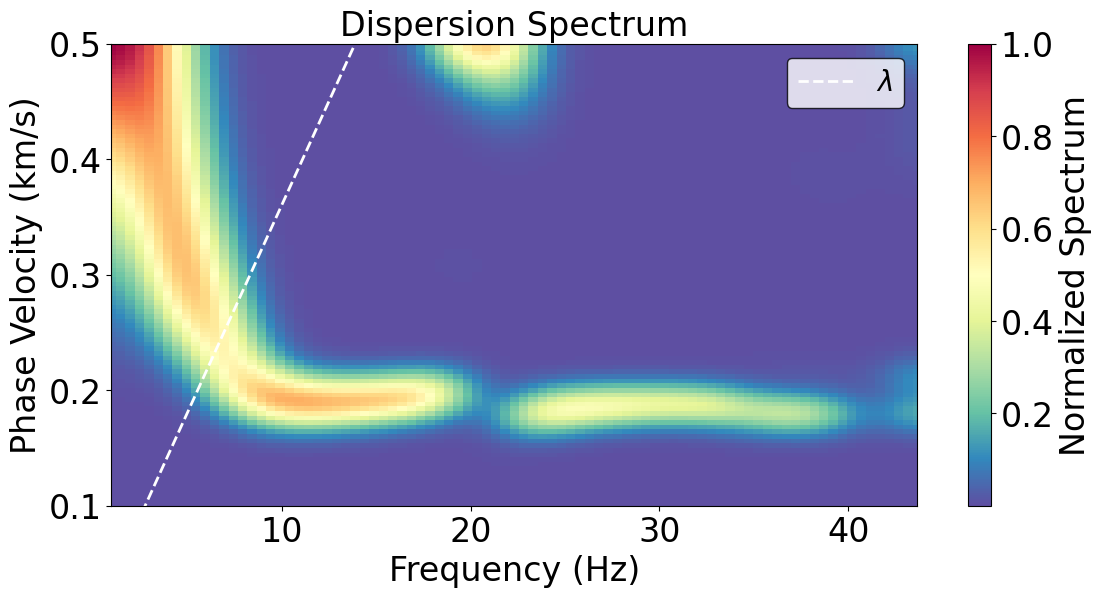

In [26]:
config = {
    'freq_min': 1,
    'freq_max': 40,
    'vel_min': 100,
    'vel_max': 500,
    'num_vel': 101,
    'part': 'both',
}

extra = {'maxiter': 400, 'method': 'L1', 'tol': 1e-4, 'reg_lambda': 100} | config

radon('./output/snr_optimal/', **extra)

### You should install CC-Fj first and then run the cell below, click https://github.com/ColinLii/CC-FJpy

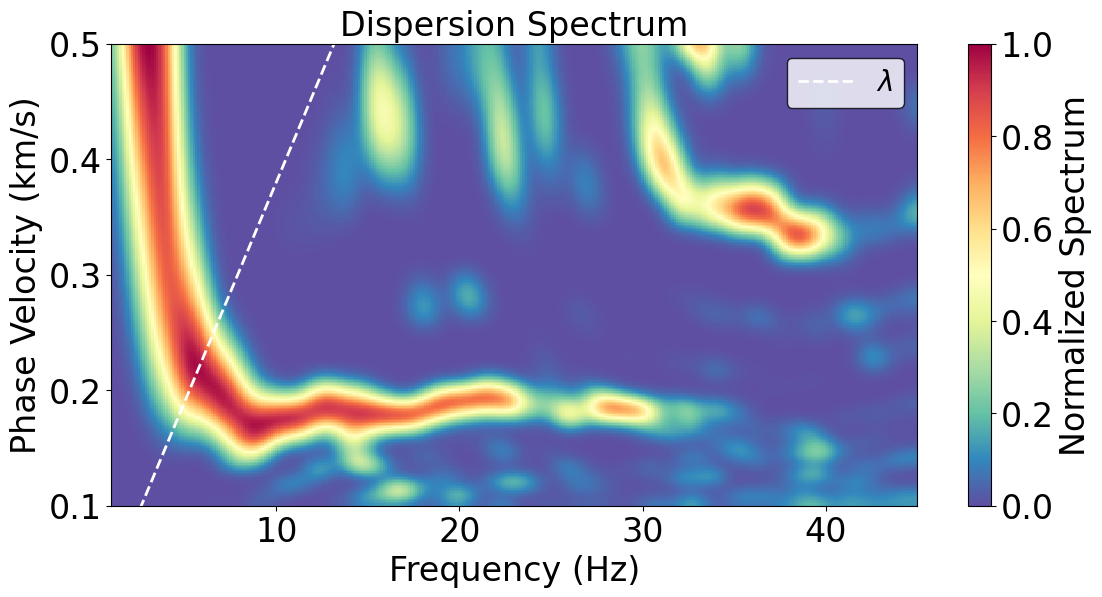

In [3]:
config = {
    'freq_min': 1,
    'freq_max': 45,
    'time_window': 15,
    'vel_min': 100,
    'vel_max': 500,
    'num_vel': 301,
    'njobs': 36,
}
fj_spectra('./CCF_ZZ', config)